In [1]:
import numpy as np
import pandas as pd
import torch
import random
import copy
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
dquery = np.load("synthetic_query_v1.npy").astype(np.float32)
dtest = np.load("synthetic_test_v1.npy").astype(np.float32)

In [3]:
dcf = np.load("64/synthetic-plaincf.npy").astype(np.float32)

In [4]:
query_x, query_y = dquery[:, 0:2], dquery[:, 2:3]
cf_x, cf_y = dcf[:, 0:2], np.round(1 - query_y).astype(np.float32)
test_x, test_y = dtest[:, 0:2], dtest[:, 2:3]

In [5]:
scaler = MinMaxScaler()
query_x = scaler.fit_transform(query_x)
test_x = scaler.transform(test_x)
cf_x = scaler.transform(cf_x)

# Select subset of query for training

In [6]:
idx = [15, 2, 13]

In [7]:
query_sx, query_sy = query_x[idx], query_y[idx]
cf_sx, cf_sy = cf_x[idx], cf_y[idx]

train_x, train_y = np.concatenate((query_sx, cf_sx), axis = 0), np.concatenate((query_sy, cf_sy), axis = 0)

In [8]:
Query = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
Test = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

In [9]:
query_loader = DataLoader(Query, batch_size  = 32)
test_loader = DataLoader(Test, batch_size = 32)

In [10]:
print(dcf)

[[1.93 1.8  0.  ]
 [2.38 2.67 0.  ]
 [2.45 2.82 0.  ]
 ...
 [3.24 4.34 0.  ]
 [3.81 5.48 0.  ]
 [2.21 2.35 0.  ]]


In [11]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    model.train()
    prediction = []
    label = []

    for batch_idx, (data, target) in enumerate(iterator):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        preds = torch.round(output)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * len(target)
        label.extend(target.tolist())
        prediction.extend(preds.reshape(-1).tolist())

    acc = accuracy_score(label, prediction)
    f1 = f1_score(label, prediction)

    return epoch_loss / len(iterator.dataset), acc, f1

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    model.eval()
    prediction = []
    label = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(iterator):

            data, target = data.to(device), target.to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            preds = torch.round(output)
            loss = criterion(output, target)
            epoch_loss += loss.item() * len(target)
            label.extend(target.tolist())
            prediction.extend(preds.reshape(-1).tolist())
            
    acc = accuracy_score(label, prediction)
    f1 = f1_score(label, prediction)

    return epoch_loss / len(iterator.dataset), acc, f1

In [12]:
model = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
    nn.Sigmoid(),
)


optimizer = optim.Adam(model.parameters(), lr = 0.005)
criterion = nn.BCELoss()
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model = model.to(device)
criterion = criterion.to(device)

best_f1 = -float('inf')
best_model = None
best_acc = -float('inf')

for epoch in range(500):

    train_loss, train_acc, train_f1 = train(model, query_loader, optimizer, criterion, device)
    
    if epoch % 50 == 0:
        print(f'Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}')
    


Epoch: 0 | Train Loss: 0.6911 | Train Acc: 0.5000 | Train F1: 0.0000
Epoch: 50 | Train Loss: 0.6106 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 100 | Train Loss: 0.4646 | Train Acc: 0.8333 | Train F1: 0.8000
Epoch: 150 | Train Loss: 0.3453 | Train Acc: 0.8333 | Train F1: 0.8000
Epoch: 200 | Train Loss: 0.2749 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 250 | Train Loss: 0.2241 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 300 | Train Loss: 0.1806 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 350 | Train Loss: 0.1436 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 400 | Train Loss: 0.1139 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 450 | Train Loss: 0.0909 | Train Acc: 1.0000 | Train F1: 1.0000


In [13]:
test_x = torch.from_numpy(test_x)
test_pred = torch.round(model(test_x)).detach().numpy()
agree = (test_pred == test_y).sum() / test_x.shape[0]

In [14]:
h= 0.02
x_min, x_max = dquery[:, 0].min() - .5, dquery[:, 0].max() + .5
y_min, y_max = dquery[:, 1].min() - .5, dquery[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                 np.arange(y_min, y_max, h))

In [15]:
dplot = np.c_[xx.ravel(), yy.ravel()]
_dplot = scaler.transform(dplot).astype(np.float32)
_dplot = torch.from_numpy(_dplot)
S = torch.round(model(_dplot)).detach().numpy()

In [16]:
S = S.reshape(xx.shape)

In [17]:
sample_positive = np.load("sample_positive.npy")
sample_negative = np.load("sample_negative.npy")

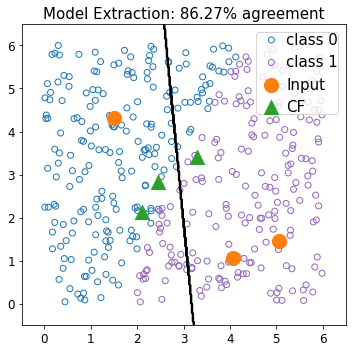

In [18]:
fig, ax = plt.subplots()
ax.tick_params(axis='both', which='major', labelsize=12)
fig.set_size_inches(5, 5)

matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
SS = S.round()
CS = ax.contour(xx, yy, SS, colors = "black")
#ax.scatter(dtest[:,0], dtest[:,1], c = dtest[:,2])
#ax.scatter(sample_positive[:, 0], sample_positive[:, 1], c = '#1f77b4', label = "class 0")
#ax.scatter(sample_negative[:, 0], sample_negative[:, 1], c = '#9467bd', label = "class 1")
ax.scatter(sample_positive[0:200, 0], sample_positive[0:200, 1], edgecolors = '#1f77b4', label = "class 0", facecolors='none')
ax.scatter(sample_negative[0:200, 0], sample_negative[0:200, 1], edgecolors = '#9467bd', label = "class 1", facecolors = 'none')

#ax.scatter(raw[idx, 0], raw[idx, 1], marker = "o", label = "Input")

ax.scatter(dquery[idx, 0], dquery[idx, 1], s= 200, color = '#ff7f0e', label = "Input")
ax.scatter(dcf[idx, 0], dcf[idx, 1], marker = "^", s = 200, label = "CF", color = '#2ca02c')
ax.legend(loc = 'upper right', fontsize = 15, handletextpad = 0, columnspacing = 0, borderpad = 0)
ax.set_title("Model Extraction: {:.2f}% agreement".format(agree * 100),fontsize = 15)
plt.tight_layout()
plt.savefig("Model Extraction.pdf", dpi = 600)
plt.show()